In [1]:
from autolens.imaging import image as im
from autolens.imaging import mask as ma
from autolens.lensing import lensing_fitting
from autolens.lensing import ray_tracing
from autolens.galaxy import galaxy as g
from autolens.lensing import lensing_image as li
from autolens.profiles import light_profiles as lp
from autolens.profiles import mass_profiles as mp
from autolens.plotting import imaging_plotters
from autolens.plotting import ray_tracing_plotters
from autolens.plotting import fitting_plotters

# In this example, we'll fit the image we simulated in the previous exercise. We'll do this using model images generated
# via a tracer, and by compairing to the simulated image we'll get diagostics about the quality of the fit.

In [2]:
# First, we load the image-data we simualted in the previous tutorial.
# Unfortunately, in a Jupyter notebook you have to manually specify the path to PyAutoLens and this tutorial.
path = 'path/to/AutoLens/workspace/howtolens/1_introduction' 
image = im.load_imaging_from_path(image_path=path + '/data/image.fits',
                                  noise_map_path=path+'/data/noise_map.fits',
                                  psf_path=path + '/data/psf.fits', pixel_scale=0.1)

In [3]:
# To fit an image, we first specify a mask. A mask describes the sections of the image that we fit. 

# Typically, we want to mask out regions of the image where the lens and source galaxies are not visible, for example
# at the edges where the signal is entirely background sky and noise.

# For the image we simulated, a 3" circular mask will do the job. 

mask = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=3.0)
print(mask) # 1 = True, which means the pixel is masked. Edge pixels are indeed masked.
print(mask[48:53, 48:53]) # Whereas central pixels are False and therefore unmasked.

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


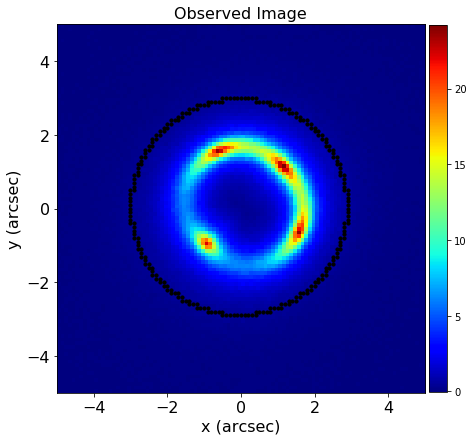

In [4]:
# We can use an imaging_plotter to compare the mask and the image - this is useful if we really want to 'tailor' a
# mask to the lensed source's light (which in this example, we won't).
imaging_plotters.plot_image(image=image, mask=mask)

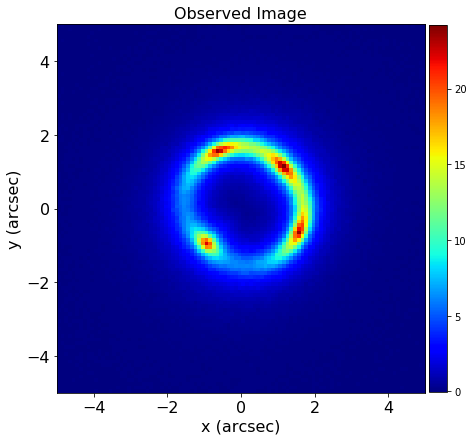

In [5]:
# Now we've loaded the image and created a mask, we use them to create a 'lensing image', which we'll perform using the
# lensing_module (imported as 'li').

# A lensing image is a 'package' of all parts of the the image data we need in order to fit it:

# 1) The image.

# 2) The PSF: so that when we compare a tracer's image-plane image to the image data we can include blurring due to 
#    the telescope optics.

# 3) The noise-map: so our goodness-of-fit measure accounts for noise in the observations.

# 4) The image's grids: so the tracer's image-plane image is generated on the same (masked) grid as the image-data.

lensing_image = li.LensingImage(image=image, mask=mask)
imaging_plotters.plot_image(lensing_image.image)

In [6]:
# By printing its attribute, we can see that it does indeed contain the image, mask, psf and so on
print('Image:')
print(lensing_image.image)
print('Noise-Map:')
print(lensing_image.image.noise_map)
print('PSF:')
print(lensing_image.image.psf)
print('Mask')
print(lensing_image.mask)
print('Grid')
print(lensing_image.grids.image)

Image:
[[-0.02811752  0.04934938  0.0201923  ... -0.03002518  0.03167547
   0.03343919]
 [-0.00400662  0.02018123 -0.00891764 ...  0.021773    0.01002246
   0.00500881]
 [ 0.02347706  0.00772293  0.01201968 ...  0.02364929  0.02843967
   0.01330815]
 ...
 [ 0.02048468  0.025265    0.02677268 ... -0.02798032 -0.00558431
   0.00685897]
 [-0.00083381  0.02052152 -0.004735   ...  0.02772293  0.0168479
  -0.01065062]
 [ 0.00789712  0.03249952 -0.00618198 ...  0.02347706  0.04266005
   0.03521582]]
Noise-Map:
[[0.01547929 0.02231213 0.02001602 ... 0.0152725  0.02095038 0.02109022]
 [0.01788793 0.0200151  0.01742435 ... 0.02014721 0.0191505  0.01870907]
 [0.02028769 0.01894931 0.01932353 ... 0.02030183 0.02069136 0.01943435]
 ...
 [0.02004035 0.02043404 0.02055664 ... 0.01549405 0.01774032 0.01887317]
 [0.01818114 0.02004341 0.01781993 ... 0.02063354 0.01973558 0.01725779]
 [0.01896463 0.02101583 0.01768408 ... 0.02028769 0.02180673 0.02123015]]
PSF:
[[2.21033495e-12 1.98968011e-10 6.58891561

In [7]:
# The shapes of these grids reveals they are 1D and have been masked:
print(lensing_image.image.shape) # This is the original 2D image
print(lensing_image.shape)
print(lensing_image.noise_map.shape)
print(lensing_image.grids.image.shape)

(100, 100)
(2828,)
(2828,)
(2828, 2)


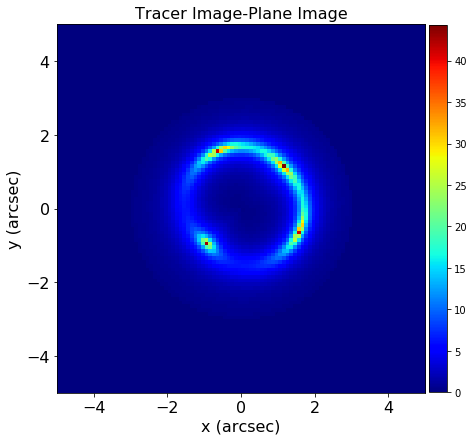

In [8]:
# To fit an image, we need to create an image-plane image using a tracer.
# Lets use the same tracer we simulated the image with (thus, our fit should be 'perfect').

# Its worth noting that below, we use the lensing_image's grids to setup the tracer. This ensures that our image-plane
# image will be the same resolution and alignment as our image-data, as well as being masked appropriately.

lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6, axis_ratio=0.7, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=45.0,
                                                        intensity=1.0, effective_radius=1.0, sersic_index=2.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=lensing_image.grids)
ray_tracing_plotters.plot_image_plane_image(tracer=tracer)

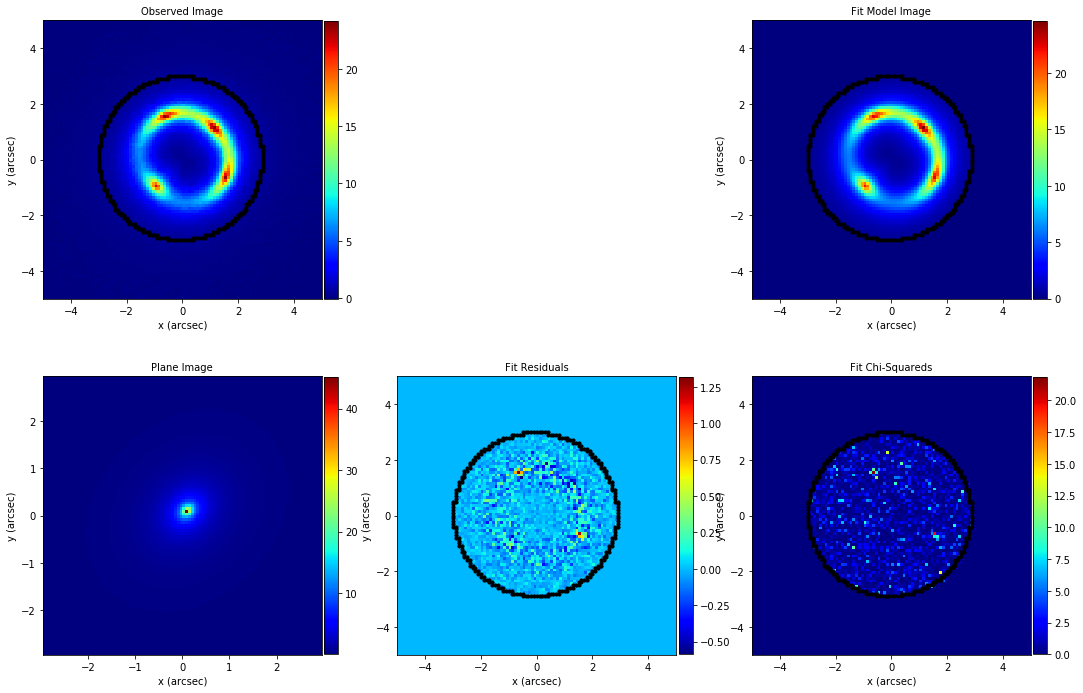

In [9]:
# To fit the image, we pass the lensing image and tracer to the fitting module. This performs the following:

# 1) Blurs the tracer's image-plane image with the lensing-image's PSF, ensuring that the telescope optics are 
#    accounted for by the fit. This creates the fit's 'model_image'.

# 2) Computes the difference between this model_image and the observed image-data, creating the fit's 'residuals'.

# 3) Divides the residuals by the noise-map and squaring each value, creating the fits 'chi-squareds'. 

# 4) Sums up these chi-squared values and converts them to a 'likelihood', which quantities how good the tracer's fit 
#    to the data was (higher likelihood = better fit).

fit = lensing_fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
fitting_plotters.plot_fitting_subplot(fit=fit)

In [10]:
# We can print the fit's attributes - if we don't specify where we'll get all zeros, as the edges were masked:
print('Model-Image Edge Pixels:')
print(fit.model_image)
print('Residuals Edge Pixels:')
print(fit.residuals)
print('Chi-Squareds Edge Pixels:')
print(fit.chi_squareds)

Model-Image Edge Pixels:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Residuals Edge Pixels:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Chi-Squareds Edge Pixels:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
# Of course, the central unmasked pixels have non-zero values.
print('Model-Image Central Pixels:')
print(fit.model_image[48:53, 48:53])
print('Residuals Central Pixels:')
print(fit.residuals[48:53, 48:53])
print('Chi-Squareds Central Pixels:')
print(fit.chi_squareds[48:53, 48:53])

Model-Image Central Pixels:
[[0.4462173  0.44749756 0.50969855 0.59504807 0.67291882]
 [0.51307485 0.47632025 0.47610663 0.50969855 0.56369804]
 [0.67722767 0.57406417 0.47632025 0.44749756 0.48543844]
 [0.85729868 0.67722767 0.51307485 0.4462173  0.46816957]
 [0.99153157 0.75929623 0.57948483 0.50150061 0.5076683 ]]
Residuals Central Pixels:
[[-0.07927903 -0.00173237 -0.02344238  0.01118258  0.00024487]
 [-0.01117733  0.0358003  -0.06113047 -0.01344238  0.04320951]
 [-0.02410329 -0.05350052  0.03246697 -0.00839903 -0.00321524]
 [-0.06182083  0.08589671 -0.00451067 -0.0259457   0.01565902]
 [-0.0726554  -0.00738017  0.00362459 -0.04811329  0.04199109]]
Chi-Squareds Central Pixels:
[[4.03811324e+00 1.64966441e-03 2.81214271e-01 5.31200784e-02
  2.32660697e-05]
 [6.22694488e-02 6.28141831e-01 2.17695544e+00 9.09161258e-02
  7.92350523e-01]
 [2.31423372e-01 1.38372874e+00 5.19444628e-01 3.92565234e-02
  5.32671174e-03]
 [1.28037190e+00 2.56448949e+00 1.00298889e-02 3.88169995e-01
  1.2599

In [12]:
# It also provides a likelihood, which is a single-figure estimate of how good the model image fitted the
# simulated image (in unmasked pixels only!).
print('Likelihood:')
print(fit.likelihood)

Likelihood:
2854.696614968532


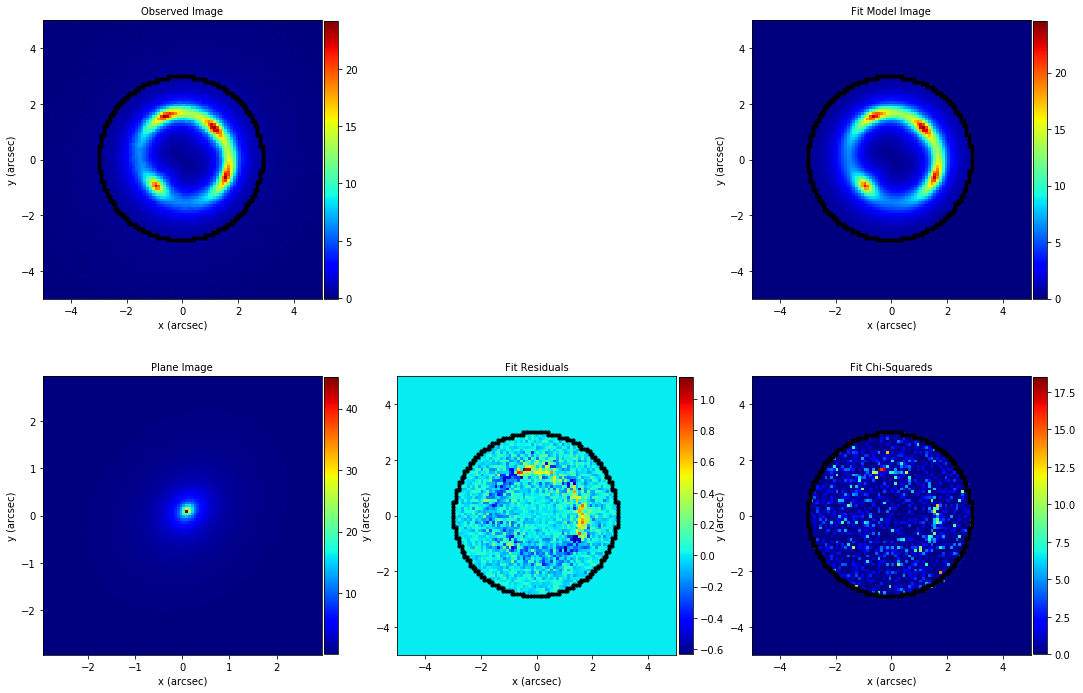

In [13]:
# We used the same tracer to create and fit the image. Therefore, our fit to the image was excellent.
# For example, by inspecting the residuals and chi-squareds, one can see no signs of the source galaxy's light present
# and we only see the noise that we simulated the image with.

# This solution should translate to one of the highest-likelihood solutions possible.

# Lets change the tracer, so that it's near the correct solution, but slightly off. 
# All we're going to do is slightly offset the lens galaxy, by 0.005"

lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.005, 0.005), einstein_radius=1.6, axis_ratio=0.7, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=45.0,
                                                        intensity=1.0, effective_radius=1.0, sersic_index=2.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=lensing_image.grids)
fit = lensing_fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
fitting_plotters.plot_fitting_subplot(fit=fit)

In [14]:
# We now observe residuals to appear at the locations the source galaxy was observed, which 
# corresponds to an increase in our chi-squareds (which determines our goodness-of-fit).

# Lets compare the likelihood to the value we computed above (which was 11697.24):
print('Previous Likelihood:')
print(11697.24)
print('New Likelihood:')
print(fit.likelihood)
# It decreases! This model was a worse fit to the data.

Previous Likelihood:
11697.24
New Likelihood:
2624.5027710365393


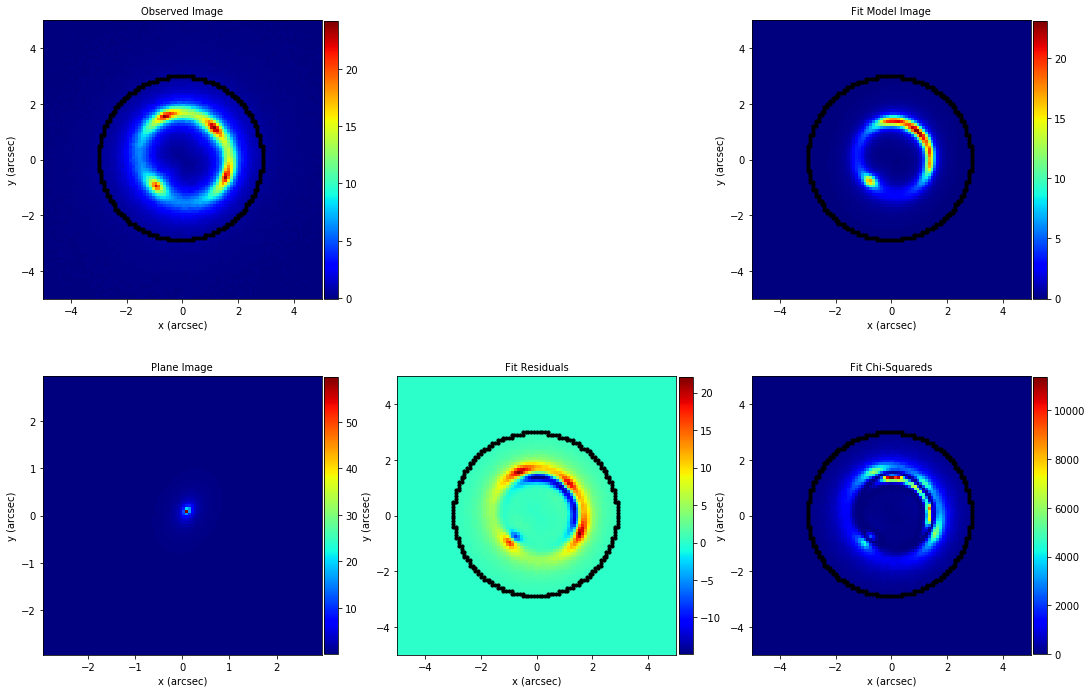

In [15]:
# Lets change the tracer, one more time, to a solution that is nowhere near the correct one.
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.005, 0.005), einstein_radius=1.3, axis_ratio=0.8, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.7, phi=65.0,
                                                        intensity=1.0, effective_radius=0.4, sersic_index=3.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=lensing_image.grids)
fit = lensing_fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
fitting_plotters.plot_fitting_subplot(fit=fit)

In [16]:
# Clearly, the model provides a terrible fit, and this tracer is not a plausible representation of 
# the image-data  (of course, we already knew that, given that we simulated it!)

# The likelihood drops dramatically, as expected.
print('Previous Likelihoods:')
print(11697.24)
print(10319.44)
print('New Likelihood:')
print(fit.likelihood)

Previous Likelihoods:
11697.24
10319.44
New Likelihood:
-1034697.3393901084


In [22]:
# Congratulations, you've fitted your first strong lens with PyAutoLens! Perform the following exercises:

# 1) In this example, we 'knew' the correct solution, because we simulated the lens ourselves. In the real Universe,
#    we have no idea what the correct solution is. How would you go about finding the correct solution? 
#    Could you find a solution that fits the data reasonable through trial and error?
